# Hybrid Search

## 0. Prerequisites
Before we begin, we must install the required libraries.

In [ ]:
!pip install redis img2vec-pytorch ipyleaflet

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Install Redis locally (optional)
If you have a Redis db running elsewhere with [Redis Stack](https://redis.io/docs/about/about-stack/) installed, you don't need to run it on this machine. You can skip to the "Connect to Redis server" step.

You can install Redis-Stack locally using the following block:

In [3]:
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


In [4]:
# Redis connection params
redis_url = "redis://127.0.0.1:6379"

### Connect to Redis server
Replace the connection params below with your own if you are connecting to an external Redis instance.

In [1]:
# Redis connection params
redis_url = "redis://redis-12000.cluster.dev-vss.demo.redislabs.com:12000"

In [25]:
import redis

# Create Redis client
redis_client = redis.from_url(redis_url)

# Test connection
redis_client.ping()

True

In [26]:
# Clear Redis database (optional)
redis_client.flushdb()

True

### Load Working Files from Github

In [29]:
#Load working files from git repository
!npx degit aelkouhen/redis-vss/ColabDrive -f

npx: installed 1 in 0.856s
> destination directory is not empty. Using --force, continuing
> cloned aelkouhen/redis-vss#HEAD


### Mount Google Drive (Optional)

Optionally, you can load the working files from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Vector Storage

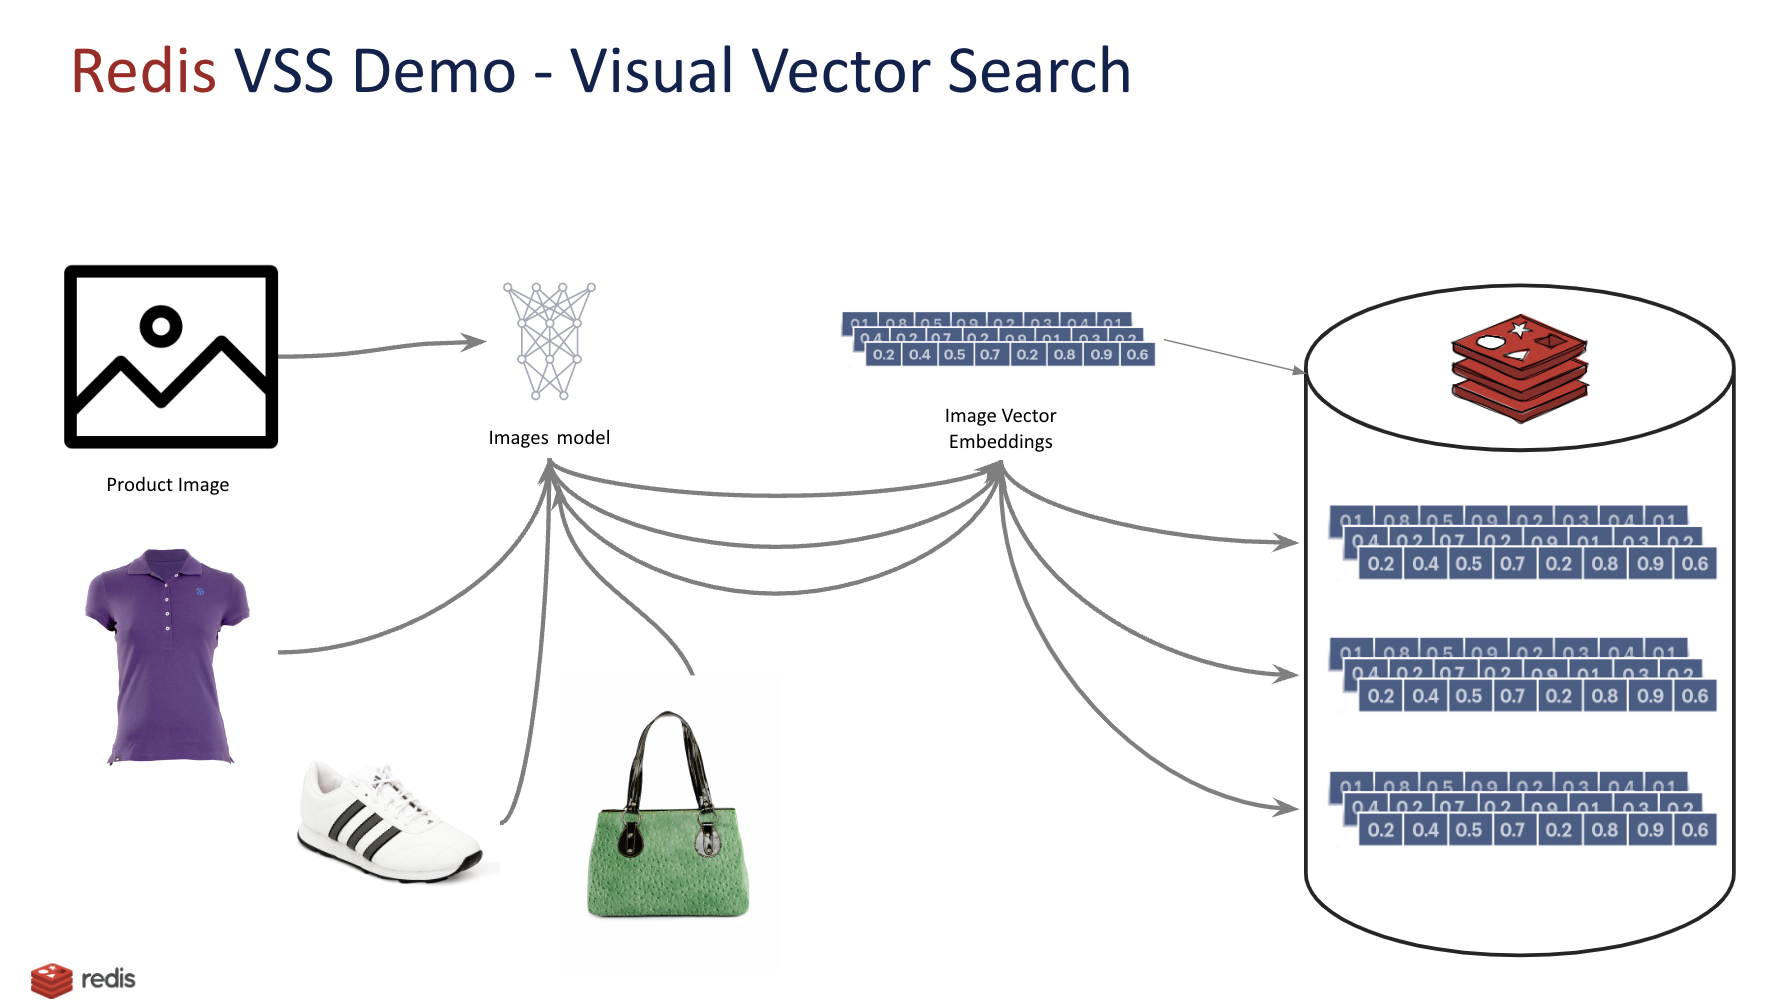

In [27]:
from PIL import Image
from typing import Generator, List, Any
from img2vec_pytorch import Img2Vec
from glob import glob
import matplotlib.pyplot as plt

import os
import redis
import json

# data prep
import pandas as pd
import numpy as np
# for creating image vector embeddings
import urllib.request

def generate_image_vector(file):
   # Resnet-18 to create image embeddings
   image_model = Img2Vec()
   img = Image.open(file).convert('RGB')
   img = img.resize((224, 224))
   return image_model.get_vec(img)

# Convert embeddings to bytes for Redis storage
def convert_embedding(emb: List[float]):
  return np.array(emb).astype(np.float32).tobytes()

# Create Dataframes from image folder
def load_products(folder):

  myDict = {
      'product_id' : [],
      'product_name' : [],
      'product_image' : [],
      'product_embedding' : [],
      'gender' : [],
      'price' : [],
      'location' : []
  }

  dir = os.path.join(f"{folder}", "*.json")
  for file in glob(dir):
    id = os.path.splitext(os.path.basename(file))[0]
    with open(file) as json_file:
        json_text = json.load(json_file)

        myDict['product_id'].append(id)
        myDict['product_name'].append(json_text['product_name'])
        myDict['product_image'].append(json_text['product_image'])
        myDict['product_embedding'].append(json_text['product_embedding'])
        myDict['gender'].append(json_text['gender'])
        myDict['price'].append(json_text['price'])
        myDict['location'].append(json_text['location'])

        redis_client.json().set(f"product:{id}", '$', json_text)

  df = pd.DataFrame(myDict)
  return df

# display product image
def display_product(file):
  img = Image.open(file).convert('RGB')
  img = img.resize((224, 224))
  plt.imshow(img)
  plt.show()

In [30]:
df = load_products("products/json")

display(df)

,product_id,product_name,product_image,product_embedding,gender,price,location
0,b3d19377041615d8a7cf46b96ef67c4c,Numero Uno Men White Casual Shoes,products/men/8cf52572340c3592e5f0ede116a0206f.jpg,"[2.1139073371887207, 2.203714370727539, 0.1904...",men,18.99,"50.69098, 3.17655"
1,7185ef5d96833937481c19a47edac96a,Nike STAR RUNNER 4,products/men/7185ef5d96833937481c19a47edac96a.jpg,"[1.3799762725830078, 1.9074944257736208, 0.181...",men,48.95,"49.85596, 3.25761"
2,7ce41800565e35b1c3603642e4b8725f,ADIDAS Women White Sukhoi Sports Shoes,products/women/7ce41800565e35b1c3603642e4b8725...,"[1.757159948348999, 0.8680879473686218, 0.2009...",women,110.00,"48.97247, 2.47544"
3,88046aefb3d87ea8418c12f6f48717fa,ADIDAS Women Green Adi Casual Shoes,products/women/88046aefb3d87ea8418c12f6f48717f...,"[1.2594374418258667, 0.9798986315727234, 0.227...",women,116.99,"50.61769, 3.02818"
4,ec28a6e80636805d0bf993699b656c88,Reebok Women Charcoal Grey Fuel Techno Sports ...,products/women/ec28a6e80636805d0bf993699b656c8...,"[1.864536166191101, 0.4866303503513336, 0.9172...",women,70.00,"50.62010, 3.08280"
5,a9d1eabd2f40affad56623f15ad76083,Force 10 Women White Shoes,products/women/a9d1eabd2f40affad56623f15ad7608...,"[1.344132423400879, 1.6654057502746582, 0.4254...",women,24.99,"46.95588, 0.51103"
6,8cf52572340c3592e5f0ede116a0206f,Numero Uno Men White Casual Shoes,products/men/8cf52572340c3592e5f0ede116a0206f.jpg,"[3.0499367713928223, 0.6722652912139893, 1.209...",men,18.99,"50.69098, 3.17655"
7,6d62ba4de5c73b36d44f6bff05d2457e,ADIDAS Unisex White Shoes,products/men/6d62ba4de5c73b36d44f6bff05d2457e.jpg,"[2.3644134998321533, 1.1548532247543335, 1.254...",men,55.00,"50.61769, 3.02818"
8,9f70a44e8105afd42debd1302a5149df,Reebok Women White Acciomax Sports Shoes,products/women/9f70a44e8105afd42debd1302a5149d...,"[1.5057373046875, 1.1765334606170654, 0.289527...",women,49.00,"48.90025, 2.24400"
9,a27cf465dade1e9dfe146683f696d57f,ADIDAS Women Trainer White Sports Shoes,products/women/a27cf465dade1e9dfe146683f696d57...,"[2.0372085571289062, 1.4192463159561155, 1.935...",women,41.95,"48.76870, 2.38773"


## 2. Vector Indexing
After creating embeddings that represent the products and storing them in Redis, we will create a secondary index that enables efficient search over the embeddings. To learn more about the vector similarity features in Redis, [check out these docs](https://redis.io/docs/interact/search-and-query/search/vectors/) and [these Redis AI resources](https://github.com/RedisVentures/redis-ai-resources).

Now, we will try to create a secondary index that enables hybrid search over the image embeddings and other fields like gender for example.

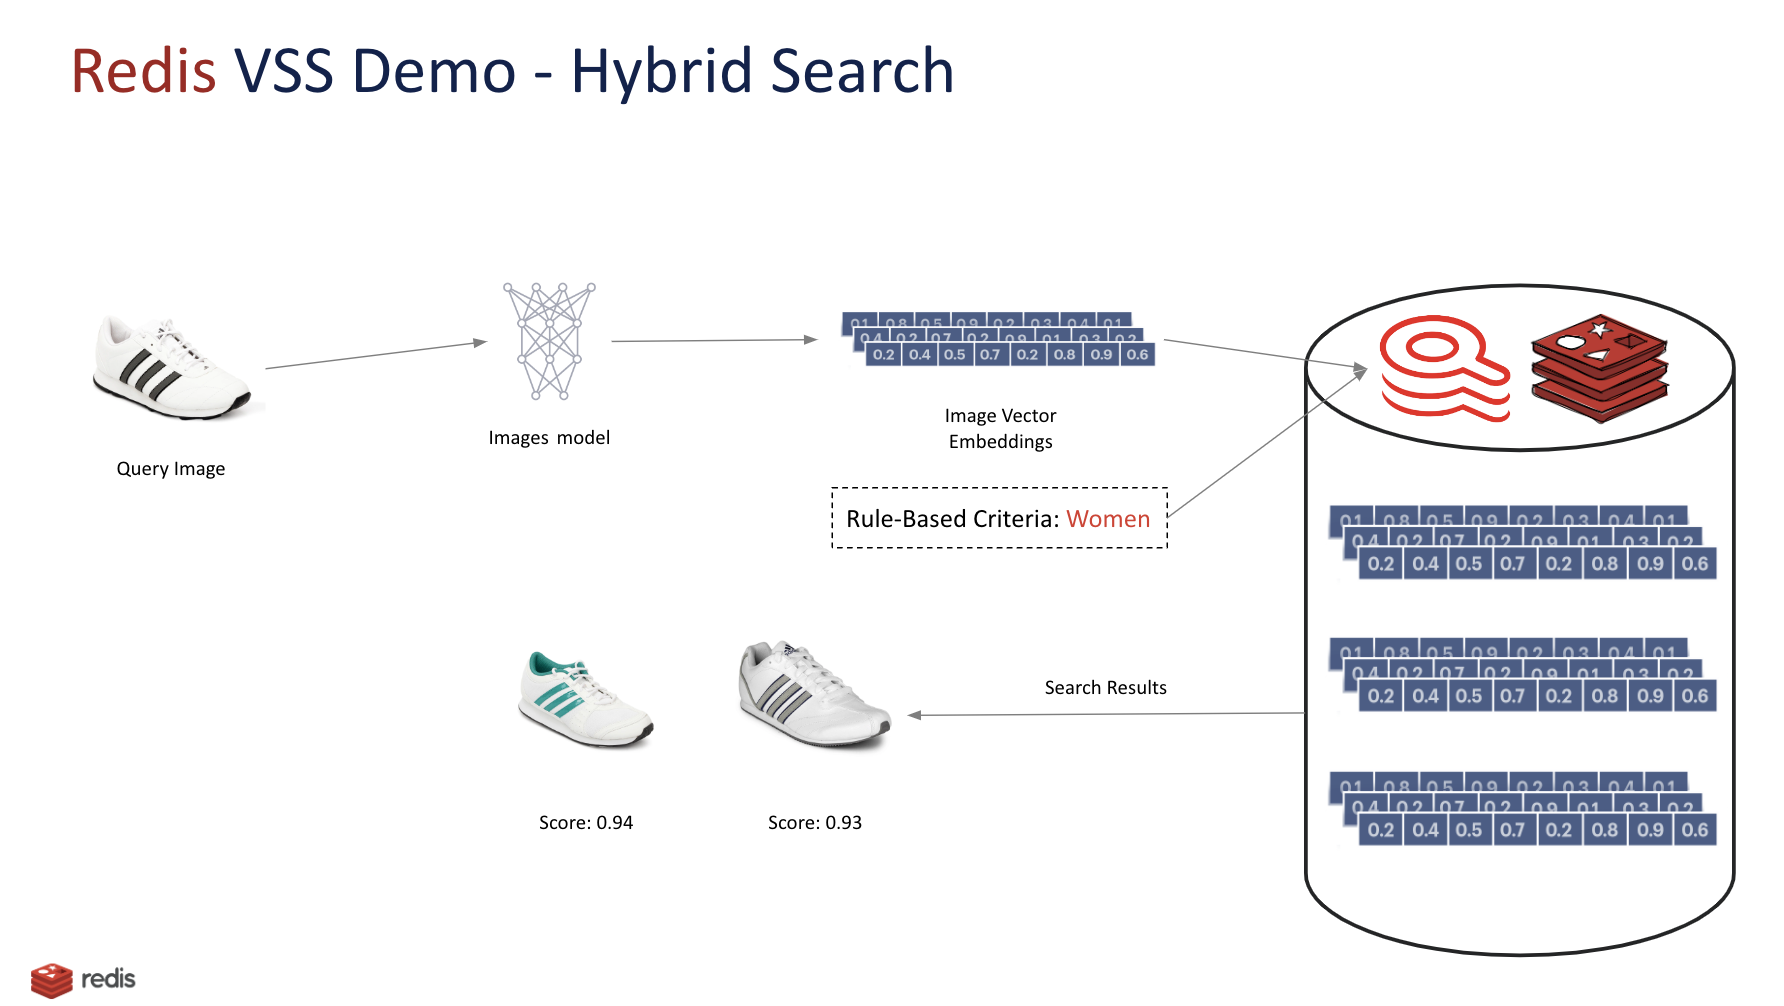

In [31]:
from redis.commands.search.field import (
    TagField,
    VectorField,
    TextField,
    NumericField,
    GeoField
)

from redis.commands.search.indexDefinition import (
    IndexDefinition,
    IndexType
)

# Function to create a hybrid search index with Image Vector Search + Tag Filtering
def create_hybrid_index(
    redis_conn,
    vector_field_name: str,
    number_of_vectors: int,
    index_name:str,
    prefix: str,
    distance_metric: str='COSINE'
):
    # Construct index
    try:
        redis_client.ft(index_name).info()
        print("Existing index found. Dropping and recreating the index", flush=True)
        redis_client.ft(index_name).dropindex(delete_documents=False)
    except:
        print("Creating new index", flush=True)

    gender_field = TagField('$.gender', as_name='gender')
    name_field = TextField('$.product_name', no_stem=True, as_name='name')
    url_field = TextField('$.product_image', no_stem=True, as_name='image')
    price_field = NumericField('$.price', as_name='price')
    location_field = GeoField('$.location', as_name='location')

    image_field = VectorField(f"{vector_field_name}", "FLAT",
                {
                    "TYPE": "FLOAT32",
                    "DIM": 512,
                    "DISTANCE_METRIC": distance_metric,
                    "INITIAL_CAP": number_of_vectors
                }, as_name='vector')

    redis_conn.ft(index_name).create_index(
        fields = [gender_field, name_field, url_field, price_field, location_field, image_field],
        definition = IndexDefinition(prefix=[prefix], index_type=IndexType.JSON)
    )

In [32]:
# 1. Create a hybrid search index for the products created earlier.
create_hybrid_index(redis_client, "$.product_embedding", 3, "product_index", 'product:')

Creating new index


## Structured Data Searches with Redis
Let's test the non-vector part of the index first:
Retrieve all products where the brand is `Adidas`

In [33]:
from redis.commands.search.query import Query

query = (
    Query('@name:%addidas%').return_fields('id', 'name', 'image', 'price')
)

# execute the search
results = redis_client.ft("product_index").search(query)
display (pd.DataFrame([t.__dict__ for t in results.docs]).drop(columns=["payload"]))

,id,name,image,price
0,product:6d62ba4de5c73b36d44f6bff05d2457e,ADIDAS Unisex White Shoes,products/men/6d62ba4de5c73b36d44f6bff05d2457e.jpg,55
1,product:a27cf465dade1e9dfe146683f696d57f,ADIDAS Women Trainer White Sports Shoes,products/women/a27cf465dade1e9dfe146683f696d57...,41.95
2,product:88046aefb3d87ea8418c12f6f48717fa,ADIDAS Women Green Adi Casual Shoes,products/women/88046aefb3d87ea8418c12f6f48717f...,116.99
3,product:7ce41800565e35b1c3603642e4b8725f,ADIDAS Women White Sukhoi Sports Shoes,products/women/7ce41800565e35b1c3603642e4b8725...,110
4,product:393e9315126350d97000721f330aa964,ADIDAS Men White Pluto Sports Shoes,products/men/393e9315126350d97000721f330aa964.jpg,47.95


Find all `Adidas` shoes with price less than or equal to `50`

In [34]:
query = (
    Query('@name:%Adidas% @price:[0 50]').return_fields('id', 'name', 'image', 'price')
)

# execute the search
results = redis_client.ft("product_index").search(query)
display (pd.DataFrame([t.__dict__ for t in results.docs]).drop(columns=["payload"]))

,id,name,image,price
0,product:a27cf465dade1e9dfe146683f696d57f,ADIDAS Women Trainer White Sports Shoes,products/women/a27cf465dade1e9dfe146683f696d57...,41.95
1,product:393e9315126350d97000721f330aa964,ADIDAS Men White Pluto Sports Shoes,products/men/393e9315126350d97000721f330aa964.jpg,47.95


Find all `Adidas` shoes near to Lille City (Latitude : 50.633333. Longitude : 3.066667) with a radius of 20km

In [35]:
query = (
    Query('@name:%Adidas% @location:[50.633333 3.066667 20 km]').return_fields('id', 'name', 'image', 'location')
)

# execute the search
results = redis_client.ft("product_index").search(query)
display (pd.DataFrame([t.__dict__ for t in results.docs]).drop(columns=["payload"]))

,id,name,image,location
0,product:6d62ba4de5c73b36d44f6bff05d2457e,ADIDAS Unisex White Shoes,products/men/6d62ba4de5c73b36d44f6bff05d2457e.jpg,"50.61769, 3.02818"
1,product:88046aefb3d87ea8418c12f6f48717fa,ADIDAS Women Green Adi Casual Shoes,products/women/88046aefb3d87ea8418c12f6f48717f...,"50.61769, 3.02818"


## Structured & Unstructured Data Searches with Redis

We create another helper function, called `hybrid_similarity_search` to create an embedding from the query image and compare it to other vectors having the same prefix according to the index created previously, in addition to the filtering by the query tag.

In [36]:
# Helper method to perform KNN similarity search in Redis
def hybrid_similarity_search(query_image: str, query_tag: str, k: int, return_fields: tuple, index_name: str = "product_index") -> list:
    # create a redis query object
    redis_query = (
        Query(f"(@gender:{{{query_tag}}})=>[KNN {k} @vector $query_vector AS distance]")
            .sort_by("distance")
            .return_fields(*return_fields)
            .paging(0, k)
            .dialect(2)
    )
    # create embedding from query text
    query_vector = np.array(generate_image_vector(query_image), dtype=np.float32).tobytes()

    # execute the search
    results = redis_client.ft(index_name).search(
        redis_query, query_params={"query_vector": query_vector}
    )
    return pd.DataFrame([t.__dict__ for t in results.docs]).drop(columns=["payload"])

Now we will query the index with the query image and the query tag.

In [37]:
# 2. Create query vector
query_image = "products/input/2eca615a43d0098f4bb5fc90004c3678.jpg"
query_tag = "women"

In [38]:
# 3. Perform the hybrid vector similarity search with the given parameters

results = hybrid_similarity_search(query_image, query_tag, k=3, return_fields=('distance', '$.product_id', '$.product_image', '$.gender'))
results['score'] = 1 - results['distance'].astype('float64')
display(results.sort_values("score", ascending=False).drop(columns=["distance"]))

,id,$.product_id,$.product_image,$.gender,score
0,product:a27cf465dade1e9dfe146683f696d57f,a27cf465dade1e9dfe146683f696d57f,products/women/a27cf465dade1e9dfe146683f696d57...,women,0.926042
1,product:7ce41800565e35b1c3603642e4b8725f,7ce41800565e35b1c3603642e4b8725f,products/women/7ce41800565e35b1c3603642e4b8725...,women,0.886814
2,product:a9d1eabd2f40affad56623f15ad76083,a9d1eabd2f40affad56623f15ad76083,products/women/a9d1eabd2f40affad56623f15ad7608...,women,0.884039


0- Product a27cf465dade1e9dfe146683f696d57f - Gender women - Score 0.9260421395302


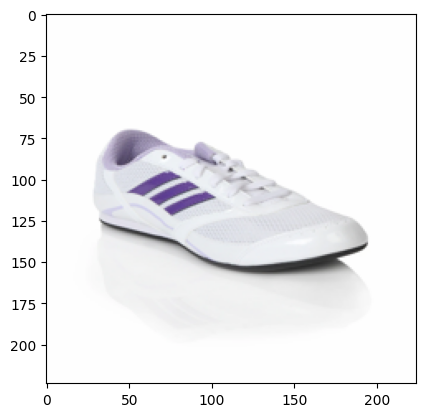

1- Product 7ce41800565e35b1c3603642e4b8725f - Gender women - Score 0.886814296246


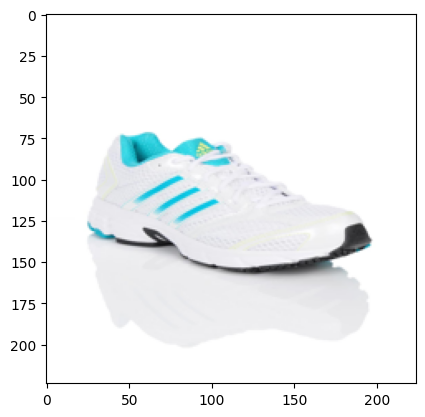

2- Product a9d1eabd2f40affad56623f15ad76083 - Gender women - Score 0.884038686752


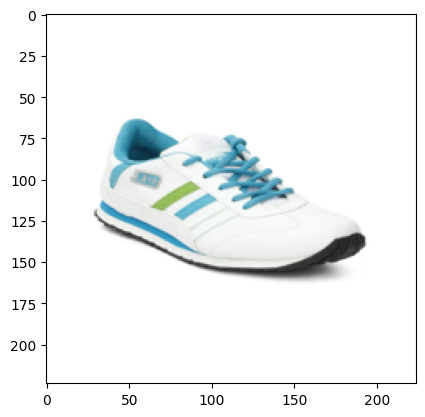

In [39]:
for index, row in results.iterrows():
  print(f"{index}- Product {row['$.product_id']} - Gender {row['$.gender']} - Score {row['score']}")
  display_product(row['$.product_image'])

Now we will query the index with the query image and ask for similar products near Paris (Latitude: 48.866667. Longitude: 2.333333).

In [40]:
# Helper method to perform KNN similarity search in Redis
def hybrid_similarity_search(query_image: str, location: str, radius: str, k: int, return_fields: tuple, index_name: str = "product_index") -> list:
    # create a redis query object
    redis_query = (
        Query(f"(@location:[{location} {radius}])=>[KNN {k} @vector $query_vector AS distance]")
            .sort_by("distance")
            .return_fields(*return_fields)
            .paging(0, k)
            .dialect(2)
    )
    # create embedding from query text
    query_vector = np.array(generate_image_vector(query_image), dtype=np.float32).tobytes()

    # execute the search
    results = redis_client.ft(index_name).search(
        redis_query, query_params={"query_vector": query_vector}
    )
    return pd.DataFrame([t.__dict__ for t in results.docs]).drop(columns=["payload"])

In [41]:
# 2. Create query vector
query_image = "products/input/2eca615a43d0098f4bb5fc90004c3678.jpg"
paris_coordinates = "48.866667 2.333333"
radius = "30 km"

In [42]:
# 3. Perform the hybrid vector similarity search with the given parameters

results = hybrid_similarity_search(query_image, paris_coordinates, radius, k=3, return_fields=('distance', '$.product_id', '$.product_image', '$.product_name', '$.location'))
results['score'] = 1 - results['distance'].astype('float64')
display(results.sort_values("score", ascending=False).drop(columns=["distance"]))

,id,$.product_id,$.product_image,$.product_name,$.location,score
0,product:a27cf465dade1e9dfe146683f696d57f,a27cf465dade1e9dfe146683f696d57f,products/women/a27cf465dade1e9dfe146683f696d57...,ADIDAS Women Trainer White Sports Shoes,"48.76870, 2.38773",0.926042
1,product:7ce41800565e35b1c3603642e4b8725f,7ce41800565e35b1c3603642e4b8725f,products/women/7ce41800565e35b1c3603642e4b8725...,ADIDAS Women White Sukhoi Sports Shoes,"48.97247, 2.47544",0.886814
2,product:9f70a44e8105afd42debd1302a5149df,9f70a44e8105afd42debd1302a5149df,products/women/9f70a44e8105afd42debd1302a5149d...,Reebok Women White Acciomax Sports Shoes,"48.90025, 2.24400",0.846211


In [43]:
# Helper method to extract coordinates from the field $.location

def extract_coordinates(location: str):
  coordinates = location.split(", ")
  return (float(coordinates[0]), float(coordinates[1]))

In [44]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker

m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=(48.866667, 2.333333),
    zoom=10
    )


for index, row in results.iterrows():
    m.add_layer(Marker(location=extract_coordinates(row['$.location']), title=row['$.product_name']))

m

Map(center=[48.866667, 2.333333], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …